#### Series Temporales

# Fases del proyecto
* Definición de metricas de eficiencia
* Serie Temporal
  * Modelo de Regresión Lineal
  * Modelo de transformación Cuadrática
  * Modelo de transformación Cúbica
  * Modelo de Transformación Logarítmica
  * Suavizado Exponencial
  * Modelo ARIMA
  * Modelo SARIMA

* Comparación de Resultados
  * Selección de Modelos
  * Ensamble

* Resultado Final

Carga de dependencias y librerías

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as math
import statsmodels.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Definición de funcion para calcular que la eficiencia del modelo y saber qué tan bien el modelo se ajusta a los datos observados.

In [14]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [13]:
#Carga del dataset
datos = pd.read_csv("datos_final_EEUU.csv")
datos.head()

,m49_code,country,region,cpc_code,commodity,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss,sample_size,method_data_collection,reference,url,notes,month,periodo
0,840,United States of America,NaN,1211.0,Asparagus,2019,9.0,9,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,12,2019-12-01
1,840,United States of America,NaN,1212.0,Cabbages,2019,7.0,7,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,9,2019-09-01
2,840,United States of America,NaN,1212.0,Cabbages,2019,8.0,8,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,1,2019-01-01
3,840,United States of America,NaN,1212.0,Cabbages,2019,12.0,12,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,7,2019-07-01
4,840,United States of America,NaN,1212.0,Cabbages,2019,12.0,12,NaN,NaN,Whole supply chain,NaN,NaN,NaN,National Accounts,NaN,https://www.ers.usda.gov/data-products/food-av...,NaN,3,2019-03-01


### Transformaciones para la generación de un modelo de Serie Temporal

Agrupación de los datos por el promedio de perdidas (loss_pecentage), índexación mediante el período con formato fecha.
Re-muestreamos los datos para obtener el promedio mensual y convertimos la serie en un dataframe.

In [15]:
datos = datos.groupby('periodo')['loss_percentage'].mean().reset_index()
datos = datos.set_index('periodo')
datos.index = pd.to_datetime(datos.index)
datos = datos['loss_percentage'].resample('MS').mean().to_frame()

### Estacionalidad
Creación de variables dummies, donde cada columna dummy representa un mes del año y Union de dichas variables con nuestro dataframe

In [16]:
datos["timeIndex"] = pd.Series(np.arange(len(datos['loss_percentage'])), index=datos.index)
datos['month'] = [d.strftime('%b') for d in datos.index]
dummies_mes = pd.get_dummies(datos['month'])
datos = datos.join(dummies_mes, on='periodo',rsuffix='_dummy')
datos.columns

Index(['loss_percentage', 'timeIndex', 'month', 'Apr', 'Aug', 'Dec', 'Feb',
       'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

### Definición de modelos
  * Modelo de Regresión Lineal + Estacionalidad
  * Modelo de transformación Cuadrática + Estacionalidad
  * Modelo de transformación Cúbica
  * Modelo de Transformación Logarítmica + Estacionalidad

In [17]:
# tendencia cuadrática
datos["timeIndex_sq"] = datos["timeIndex"]**2
# tendencia cubica
datos["timeIndex_sq_2"] = datos["timeIndex"]**3
# Trasformación logarítmica
datos['log_loss_percentage'] = np.log(datos['loss_percentage'])

In [18]:
datos.head(100)

,loss_percentage,timeIndex,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,timeIndex_sq,timeIndex_sq_2,log_loss_percentage
periodo,,,,,,,,,,,,,,,,,,
2000-01-01,6.972821,0,Jan,False,False,False,False,True,False,False,False,False,False,False,False,0,0,1.942020
2000-02-01,5.374647,1,Feb,False,False,False,True,False,False,False,False,False,False,False,False,1,1,1.681693
2000-03-01,6.862906,2,Mar,False,False,False,False,False,False,False,True,False,False,False,False,4,8,1.926131
2000-04-01,5.644510,3,Apr,True,False,False,False,False,False,False,False,False,False,False,False,9,27,1.730683
2000-05-01,8.170635,4,May,False,False,False,False,False,False,False,False,True,False,False,False,16,64,2.100547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-01,6.496755,95,Dec,False,False,True,False,False,False,False,False,False,False,False,False,9025,857375,1.871303
2008-01-01,15.566886,96,Jan,False,False,False,False,True,False,False,False,False,False,False,False,9216,884736,2.745146
2008-02-01,13.300000,97,Feb,False,False,False,True,False,False,False,False,False,False,False,False,9409,912673,2.587764


###Visualización
Descomposición de la estacionalidad y gráficas de los componentes descompuestos (tendencia, estacionalidad y residuo).

<Figure size 1600x1000 with 0 Axes>

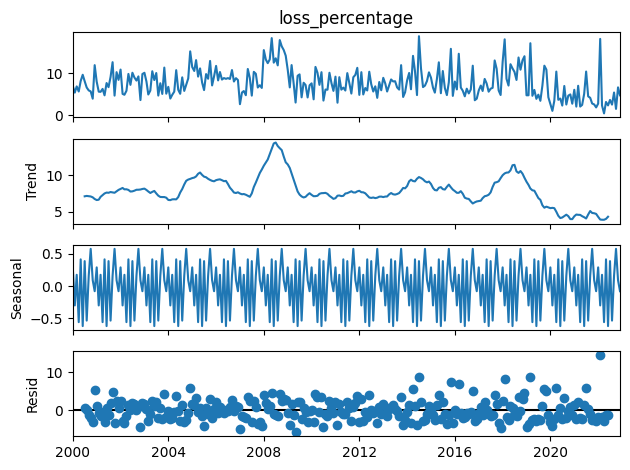

In [19]:
#Descomposición
plt.figure(figsize=(16,10))
decomposition = smt.tsa.seasonal_decompose(datos.loss_percentage, model='additive')  # Assuming yearly seasonality
decomposition.plot()
plt.show()

## Modelo de Regresión Lineal

Separación del dataset dejando un 20% para Test

In [20]:
#seasonal_decompose
datos["estacionalidad"] = decomposition.seasonal

#Train/Test
df_train, df_test = train_test_split(datos, test_size=0.2, random_state=42, shuffle=False)

#Regresion lineal
print("----------------------Regresión Lineal + Estacionalidad-------------------------------------------------------")
#Modelo
model_linear = smf.ols(formula='loss_percentage ~ timeIndex + estacionalidad', data = df_train).fit()

#Prediccion
df_train["EstLinearTrend"] = model_linear.predict(df_train[["timeIndex","estacionalidad"]])
df_test["EstLinearTrend"] = model_linear.predict(df_test[["timeIndex","estacionalidad"]])

----------------------Regresión Lineal + Estacionalidad-------------------------------------------------------


Visualización de los resultados obtenidos

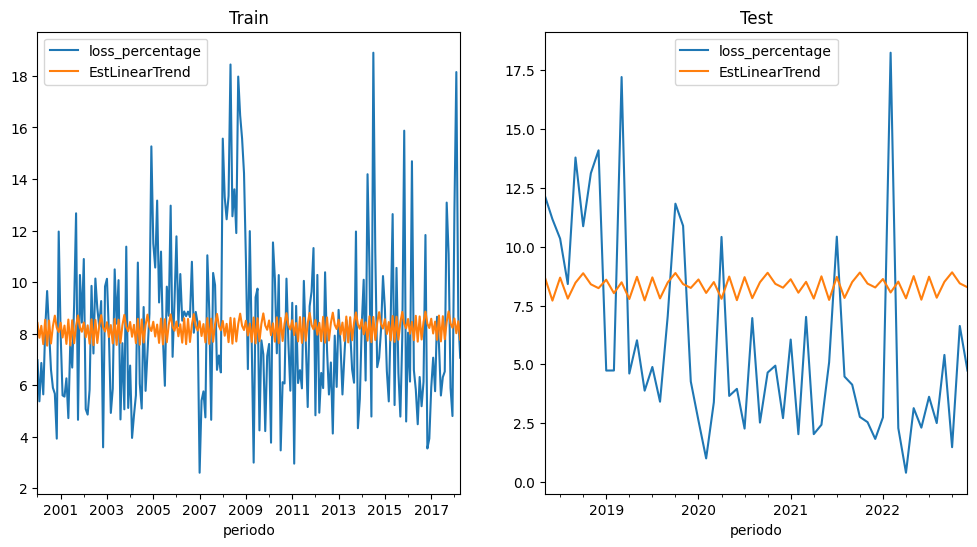

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


In [21]:
#Gráficos
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["loss_percentage","EstLinearTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["loss_percentage","EstLinearTrend"],ax=axes[1],title='Test');
plt.show()

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

Medición del Error Cuadratico Medio como variable de performance y visualización de resultados en Test y Train

In [22]:
#Medición
residuos_regresionLineal = df_train["loss_percentage"] - df_train["EstLinearTrend"]
df_Results = pd.DataFrame()
model_RMSE = RMSE(df_test.EstLinearTrend, df_test.loss_percentage)
df_Results.loc[0, "Model"] = "EstLinearTrend"
df_Results.loc[0, "RMSE"] = model_RMSE
print(df_Results.head())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Resumen
print(model_linear.summary())

#Control
print(df_train.head())
print(df_test.head())

            Model    RMSE
0  EstLinearTrend  4.8453
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:        loss_percentage   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.683
Date:                Thu, 23 May 2024   Prob (F-statistic):              0.188
Time:                        01:34:23   Log-Likelihood:                -561.60
No. Observations:                 220   AIC:                             1129.
Df Residuals:                     217   BIC:                             1139.
Df Model:                           2                                         
Covariance Type:            nonrobust    

## Modelo Transformación Cuadrática con Estacionalidad

Definición de función

In [23]:
#Función Cuadrática
print("----------------------Función Cuadrática + estacionalidad-------------------------------------------------------")
#Modelo
model_cuadratic = smf.ols('loss_percentage ~ timeIndex + timeIndex_sq + estacionalidad', data = df_train).fit()
df_train["EstCuadraticTrend"] = model_cuadratic.predict(df_train[["timeIndex","timeIndex_sq","estacionalidad"]])
df_test["EstCuadraticTrend"] = model_cuadratic.predict(df_test[["timeIndex","timeIndex_sq","estacionalidad"]])

----------------------Función Cuadrática + estacionalidad-------------------------------------------------------


Visualización de los resultados obtenidos

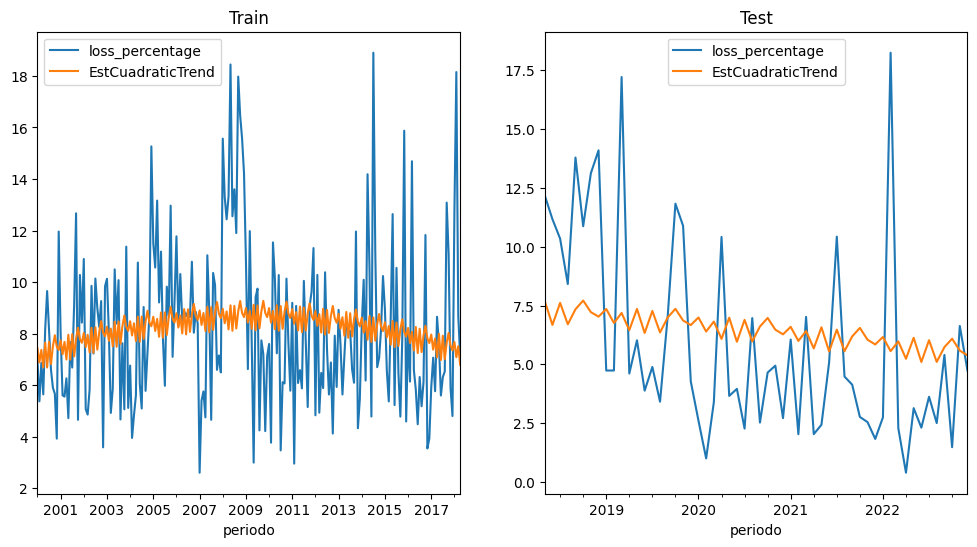

In [24]:
#Gráfico
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["loss_percentage","EstCuadraticTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["loss_percentage","EstCuadraticTrend"],ax=axes[1],title='Test');
plt.show()

Cálculo de Residuos

In [25]:
#Residuos
residuos_cuadraticTransform = df_train["loss_percentage"] - df_train["EstCuadraticTrend"]

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


Medición del Error Cuadratico Medio como variable de performance y visualización de resultados en Test y Train

In [26]:
#Medición
model_RMSE_1 = RMSE(df_test.EstCuadraticTrend, df_test.loss_percentage)
df_Results.loc[1, "Model"] = "EstCuadraticTrend"
df_Results.loc[1, "RMSE"] = model_RMSE_1
print(df_Results.head())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Resumen
print(model_cuadratic.summary())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Control
print(df_train.head())
print(df_test.head())


               Model      RMSE
0     EstLinearTrend  4.845300
1  EstCuadraticTrend  3.992503
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:        loss_percentage   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.666
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0488
Time:                        01:34:39   Log-Likelihood:                -559.30
No. Observations:                 220   AIC:                             1127.
Df Residuals:                     216   BIC:                             1140.
Df Model:                           3                                         


## Modelo de Transformación Cúbica

Definición de función

In [27]:
#Modelo Cúbico
print("----------------------Función Cúbica-------------------------------------------------------")
#Modelo
model_cubic = smf.ols('loss_percentage ~ timeIndex + timeIndex_sq + timeIndex_sq_2', data = df_train).fit()
df_train["CubicTrend"] = model_cubic.predict(df_train[["timeIndex","timeIndex_sq","timeIndex_sq_2"]])
df_test["CubicTrend"] = model_cubic.predict(df_test[["timeIndex","timeIndex_sq","timeIndex_sq_2"]])

----------------------Función Cúbica-------------------------------------------------------


Visualización de los resultados obtenidos

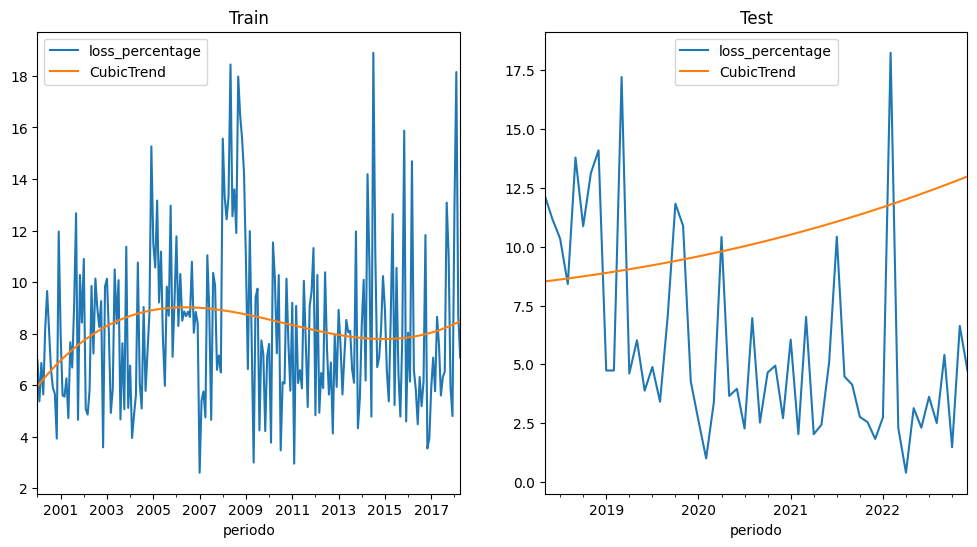

In [28]:
#Gráfico
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df_train.plot(kind = "line", y = ["loss_percentage","CubicTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["loss_percentage","CubicTrend"],ax=axes[1],title='Test');
plt.show()


Cálculo de Residuos

In [29]:
#Residuos train
residuos_cubicTrend = df_train['loss_percentage'] - df_train['CubicTrend']

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


Medición del Error Cuadratico Medio como variable de performance y visualización de resultados en Test y Train

In [30]:
#Medición
model_RMSE_2 = RMSE(df_test.CubicTrend, df_test.loss_percentage)
df_Results.loc[2, "Model"] = "CubicTrend"
df_Results.loc[2, "RMSE"] = model_RMSE_2
print(df_Results.head())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Resumen
print(model_cubic.summary())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Control
print(df_train.head())
print(df_test.head())


               Model      RMSE
0     EstLinearTrend  4.845300
1  EstCuadraticTrend  3.992503
2         CubicTrend  6.636934
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:        loss_percentage   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.181
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0249
Time:                        01:34:52   Log-Likelihood:                -558.54
No. Observations:                 220   AIC:                             1125.
Df Residuals:                     216   BIC:                             1139.
Df Model:                           3           

## Modelo de Regresión Logarítmica con Estacionalidad

Definición del Modelo

In [31]:
#Trasformación logarítmica con estacionalidad
print("----------------------Trasformación logarítmica con estacionalidad----------------------------------------------")

#Modelo
model_log = smf.ols('log_loss_percentage ~ timeIndex  + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec', data = df_train).fit()
#model_log = smf.ols('log_loss_percentage ~ timeIndex', data = df_train).fit()

#Predicción
df_train["LogTrend"] = model_log.predict(df_train[["timeIndex","Feb","Mar","Apr","May", "Jun","Jul","Aug","Sep", "Oct","Nov", "Dec"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex","Feb","Mar","Apr","May", "Jun","Jul","Aug","Sep", "Oct","Nov", "Dec"]])
#df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
#df_test["LogTrend"] = model_log.predict(df_test[["timeIndex",]])

#Destransformación
df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

----------------------Trasformación logarítmica con estacionalidad----------------------------------------------


Visualización de los resultados obtenidos

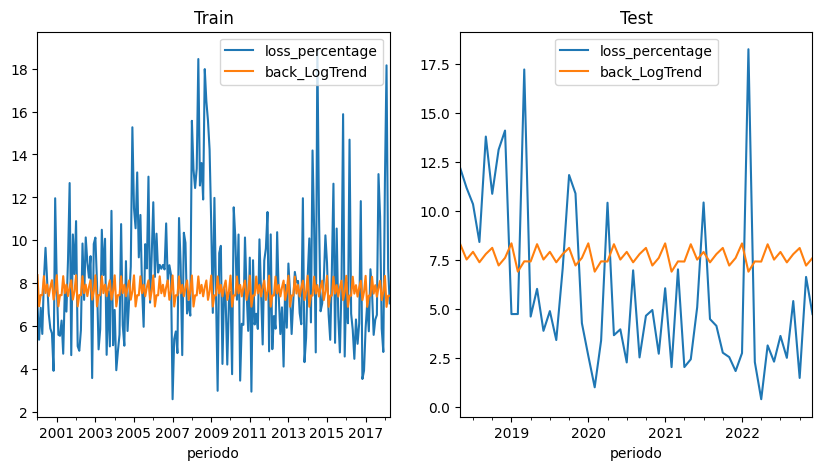

In [32]:
#Graficos
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["loss_percentage","back_LogTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["loss_percentage","back_LogTrend"],ax=axes[1],title='Test');
plt.show()


Cálculo de Residuos

In [33]:
#Residuos train
residuos_back_log_est = df_train['loss_percentage'] - df_train['back_LogTrend']

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


Medición del Error Cuadratico Medio como variable de performance y visualización de resultados en Test y Train

In [34]:
#Métricas
model_RMSE_3 = RMSE(df_test.back_LogTrend, df_test.loss_percentage)
df_Results.loc[3, "Model"] = "back_LogTrend"
df_Results.loc[3, "RMSE"] = model_RMSE_3
print(df_Results.head())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Summary
print(model_log.summary())

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Control
print(df_train.head())
print(df_test.head())

               Model      RMSE
0     EstLinearTrend  4.845300
1  EstCuadraticTrend  3.992503
2         CubicTrend  6.636934
3      back_LogTrend  4.606147
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
                             OLS Regression Results                            
Dep. Variable:     log_loss_percentage   R-squared:                       0.022
Model:                             OLS   Adj. R-squared:                 -0.035
Method:                  Least Squares   F-statistic:                    0.3862
Date:                 Thu, 23 May 2024   Prob (F-statistic):              0.967
Time:                         01:35:05   Log-Likelihood:                -94.530
No. Observations:                  220   AIC:                             215.1
Df Residuals:                      207   BIC:                             259.2
Df Model:

## Cálculo de Media Movil

----------------------------------Media Móvil----------------------------------------------
4.281275277777777
4.060795152777777
3.3554109537037036
El siguiente valor predicho es: 3.8991604614197524


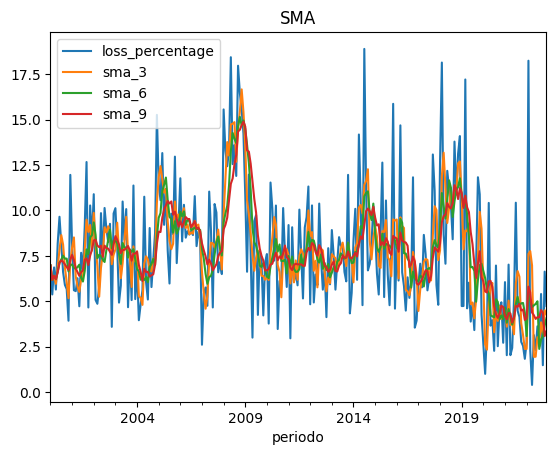

In [35]:
#Media movil
print("----------------------------------Media Móvil----------------------------------------------")

datos["sma_3"] = datos.loss_percentage.rolling(3,min_periods=1).mean()
datos["sma_6"] = datos.loss_percentage.rolling(6,min_periods=1).mean()
datos["sma_9"] = datos.loss_percentage.rolling(9,min_periods=1).mean()
datos.plot(kind = "line", y = ["loss_percentage","sma_3","sma_6","sma_9"],title='SMA')

# Últimos valores de los promedios móviles
ultimo_sma_3 = datos["sma_3"].iloc[-1]
ultimo_sma_6 = datos["sma_6"].iloc[-1]
ultimo_sma_9 = datos["sma_9"].iloc[-1]

print(ultimo_sma_3)
print(ultimo_sma_6)
print(ultimo_sma_9)

# Predicción del siguiente valor
siguiente_valor = (ultimo_sma_3 + ultimo_sma_6 + ultimo_sma_9) / 3
print("El siguiente valor predicho es:", siguiente_valor)

## Modelo Suavizado Exponencial

Definición del modelo

In [36]:
#Suavizado exponencial
print("----------------------------------Suavizado exponencial ----------------------------------------------")

#Modelo
modelo_suavizado = SimpleExpSmoothing(df_train.loss_percentage)
modelo_suavizado = modelo_suavizado.fit(smoothing_level=0.9,optimized=False)

#Predicción
df_train["Simple_Smoothing_9"] = modelo_suavizado.predict(start=df_train.index[0], end=df_train.index[-1])
df_test["Simple_Smoothing_9"] = modelo_suavizado.predict(start=df_test.index[0], end=df_test.index[-1])

----------------------------------Suavizado exponencial ----------------------------------------------


Visualización de los resultados obtenidos

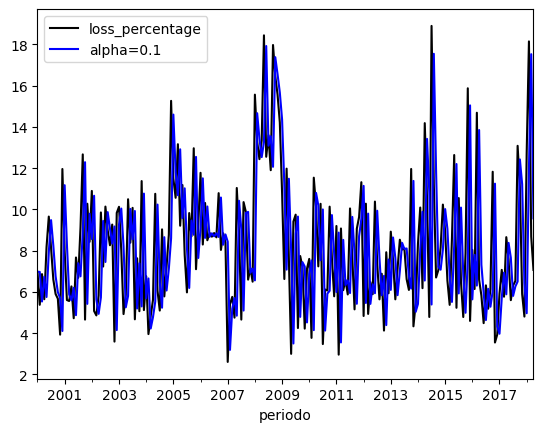

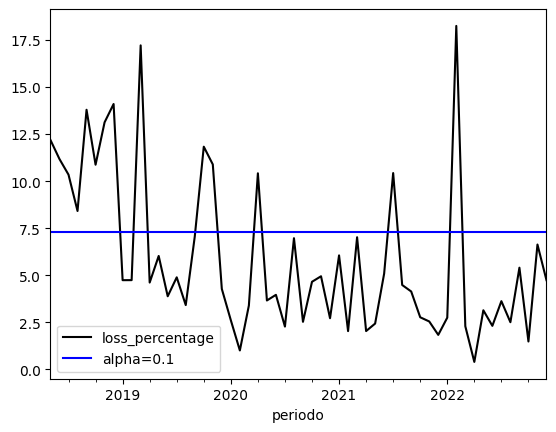

In [37]:
#Gráficos
df_train.plot(kind = "line", y = "loss_percentage",color='black')
df_train["Simple_Smoothing_9"].plot(label="alpha=0.1",color='b');
plt.legend();

df_test.plot(kind = "line", y = "loss_percentage",color='black')
df_test["Simple_Smoothing_9"].plot(label="alpha=0.1",color='b');
plt.legend()


Cálculo de Residuos

In [38]:
#Residuos train
residuos_suavizado_09 = df_train['loss_percentage'] - df_train['Simple_Smoothing_9']

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")


-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


Medición del Error Cuadratico Medio como variable de performance y visualización de resultados en Test y Train

In [39]:
# Métricas
model_RMSE_4 = RMSE(df_test["Simple_Smoothing_9"], df_test.loss_percentage)
df_Results.loc[4, "Model"] = "Simple Smoothing a=0.9";
df_Results.loc[4, "RMSE"] = model_RMSE_4
print(df_Results)

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Summary
print(modelo_suavizado.summary())

#Control
print(df_train.head())
print(df_test.head())

                    Model      RMSE
0          EstLinearTrend  4.845300
1       EstCuadraticTrend  3.992503
2              CubicTrend  6.636934
3           back_LogTrend  4.606147
4  Simple Smoothing a=0.9  4.430907
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
                       SimpleExpSmoothing Model Results                       
Dep. Variable:        loss_percentage   No. Observations:                  220
Model:             SimpleExpSmoothing   SSE                           3022.418
Optimized:                      False   AIC                            580.441
Trend:                           None   BIC                            587.228
Seasonal:                        None   AICC                           580.627
Seasonal Periods:                None   Date:                 Thu, 23 May 2024
Box-Cox:                        Fal

## Modelo ARIMA

Definición de residuos a utilizar y visualización

----------------------------------Modelo Arima----------------------------------------------


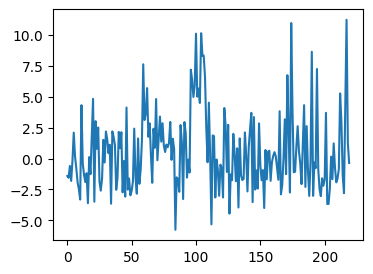

In [53]:
#Modelo ARIMA
print("----------------------------------Modelo Arima----------------------------------------------")

#Vamos a trabajar con los residuos con transformación logarítmica y estacionalidad
residuos_finales = residuos_back_log_est

#Gráfico de Residuos
plt.figure(figsize=(4,3))
plt.plot(df_train.timeIndex, residuos_finales, '-')
plt.show();

Test de Dickey-Fuller Aumentado para verificación de Estacionalidad

In [54]:
#Test de Dickey-Fuller aumentado
#Aplicamos el test de Dickey-Fuller aumentado, ADF, para validar que es estacionaria.
#Muestra un p-value menor a 5%, por lo tanto es estacionaria. La podemos usar para el modelo ARIMA.
result = adfuller(residuos_finales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -4.376761
p-value: 0.000326
Valor crítico 1%: -3.46
Valor crítico 5%: -2.88
Valor crítico 10%: -2.57


Gráficos de autocorrelación

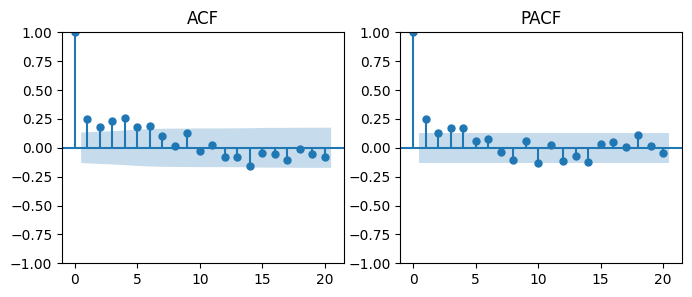

In [55]:
#Gráficos de autocorrelación
fig, axes = plt.subplots(1, 2,figsize=(8,3))
plot_acf(residuos_finales, lags=20,ax=axes[0],title='ACF')
plot_pacf(residuos_finales, lags=20,ax=axes[1],title='PACF')
plt.show()

Definición del modelo y resultados

In [56]:
#Modelo
model_ARIMA = ARIMA(residuos_finales, order=(1,0,1))
results_ARIMA = model_ARIMA.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -547.484
Date:                Thu, 23 May 2024   AIC                           1102.967
Time:                        01:35:25   BIC                           1116.542
Sample:                    01-01-2000   HQIC                          1108.449
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5448      0.527      1.035      0.301      -0.487       1.577
ar.L1          0.8703      0.069     12.603      0.000       0.735       1.006
ma.L1         -0.6907      0.105     -6.572      0.0

Gráficos de Normalidad para los residuos

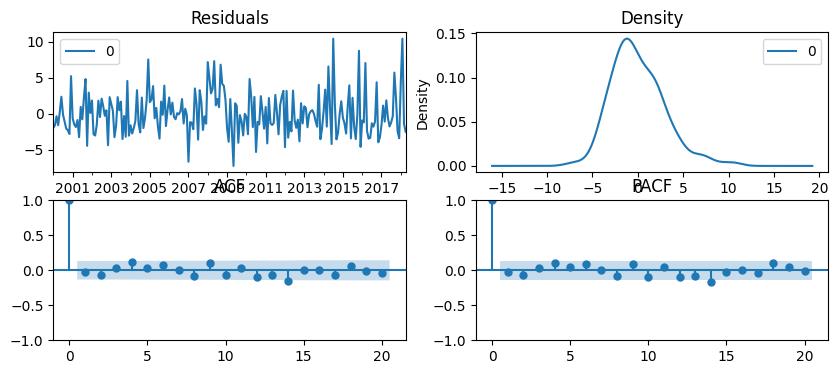

In [57]:
#Gráficos de normalidad de los residuos del ARIMA
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(10,4))
residuals.plot(title="Residuals", ax=axes[0,0]);
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
plot_acf(residuals, lags=20,ax=axes[1,0],title='ACF');
plot_pacf(residuals, lags=20,ax=axes[1,1],title='PACF')
plt.show()

Predicción y Resultados

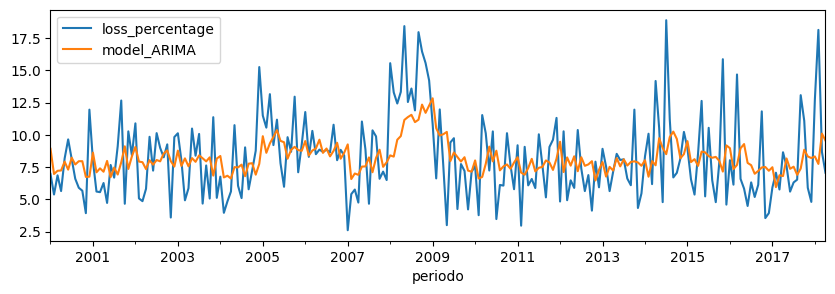

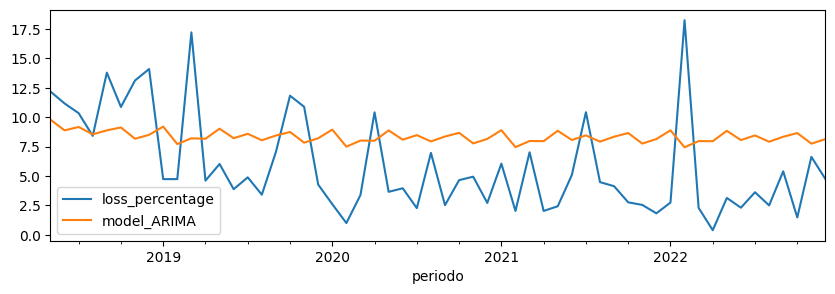

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


In [58]:
#Predicción
predictions_ARIMA = results_ARIMA.forecast(len(df_test['loss_percentage']))
df_train['model_ARIMA'] = df_train['back_LogTrend'] + results_ARIMA.fittedvalues
df_test['model_ARIMA'] = df_test['back_LogTrend']  + predictions_ARIMA

#Gráficos
df_train.plot(kind = "line", y = ['loss_percentage', 'model_ARIMA'],figsize=(10,3));plt.show()
df_test.plot(kind = "line", y = ['loss_percentage', 'model_ARIMA'],figsize=(10,3));plt.show()

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

Evaluación de Performance

In [59]:
#Métricas
model_RMSE_5 = RMSE(df_test['model_ARIMA'], df_test['loss_percentage'])
df_Results.loc[5, "Model"] = "back_LogTrend + ARIMA"
df_Results.loc[5, "RMSE"] = model_RMSE_5
print(df_Results)

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Control
print(df_train.head())
print(df_test.head())


                    Model      RMSE
0          EstLinearTrend  4.845300
1       EstCuadraticTrend  3.992503
2              CubicTrend  6.636934
3           back_LogTrend  4.606147
4  Simple Smoothing a=0.9  4.430907
5   back_LogTrend + ARIMA  4.805727
6  back_LogTrend + SARIMA  4.297213
7                Ensamble  4.292018
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
            loss_percentage  timeIndex month    Apr    Aug    Dec    Feb  \
periodo                                                                    
2000-01-01         6.972821          0   Jan  False  False  False  False   
2000-02-01         5.374647          1   Feb  False  False  False   True   
2000-03-01         6.862906          2   Mar  False  False  False  False   
2000-04-01         5.644510          3   Apr   True  False  False  False   
2000-05-01         8.170

## Modelo SARIMA

Definición del modelo

In [47]:
#Modelo SARIMA
print("----------------------------------Modelo SARIMA----------------------------------------------")

#Modelo
modelo_SARIMAX = SARIMAX(endog = residuos_finales, order = (1, 0, 1), seasonal_order = (1, 0, 1, 12))
results_sarimax = modelo_SARIMAX.fit(disp=0)

----------------------------------Modelo SARIMA----------------------------------------------


Definición de los datos de train, test y visualización de las series

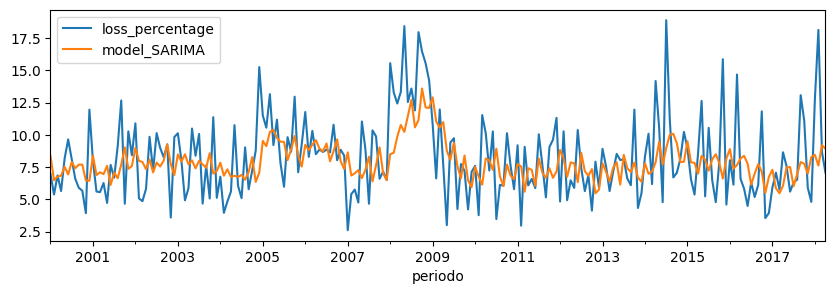

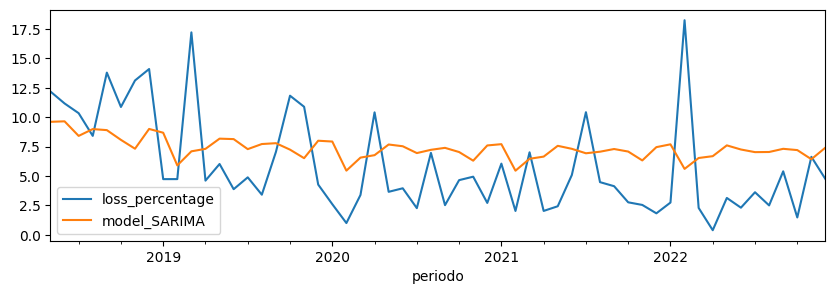

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


In [48]:
#Predicción
predictions_SARIMA = results_sarimax.forecast(len(df_test['loss_percentage']))
df_train['model_SARIMA'] = df_train['back_LogTrend'] + results_sarimax.fittedvalues
df_test['model_SARIMA'] = df_test['back_LogTrend'] + predictions_SARIMA

# Trama la serie original y la serie predicha en un gráfico TRAIN
df_train.plot(kind = "line", y = ['loss_percentage', 'model_SARIMA'],figsize=(10,3));plt.show()
df_test.plot(kind = "line", y = ['loss_percentage', 'model_SARIMA'],figsize=(10,3));plt.show()

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

Evaluación de Performance

In [49]:
#Métricas
model_RMSE_6 = RMSE(df_test['model_SARIMA'], df_test['loss_percentage'])
df_Results.loc[6, "Model"] = "back_LogTrend + SARIMA"
df_Results.loc[6, "RMSE"] = model_RMSE_6
print(df_Results)

print("-------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------")

#Control
print(df_train.head())
print(df_test.head())


                    Model      RMSE
0          EstLinearTrend  4.845300
1       EstCuadraticTrend  3.992503
2              CubicTrend  6.636934
3           back_LogTrend  4.606147
4  Simple Smoothing a=0.9  4.430907
5   back_LogTrend + ARIMA  4.805727
6  back_LogTrend + SARIMA  4.297213
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
            loss_percentage  timeIndex month    Apr    Aug    Dec    Feb  \
periodo                                                                    
2000-01-01         6.972821          0   Jan  False  False  False  False   
2000-02-01         5.374647          1   Feb  False  False  False   True   
2000-03-01         6.862906          2   Mar  False  False  False  False   
2000-04-01         5.644510          3   Apr   True  False  False  False   
2000-05-01         8.170635          4   May  False  False  

### Ensamble

**Se combinan las predicciones de tres modelos** (Función cuadrática + Estacionalidad, ARIMA y SARINA). Se toma el promedio de las predicciones de cada uno y se guardan en el dataset de test

In [50]:
y_pred_EstCuadraticTrend = df_test["EstCuadraticTrend"]
y_pred_model_ARIMA = df_test['model_ARIMA']
y_pred_model_SARIMA = df_test['model_SARIMA']
df_test["result_ensamble"] = (y_pred_EstCuadraticTrend + y_pred_model_ARIMA + y_pred_model_SARIMA) / 3

Analisis de métricas a través de gráfico

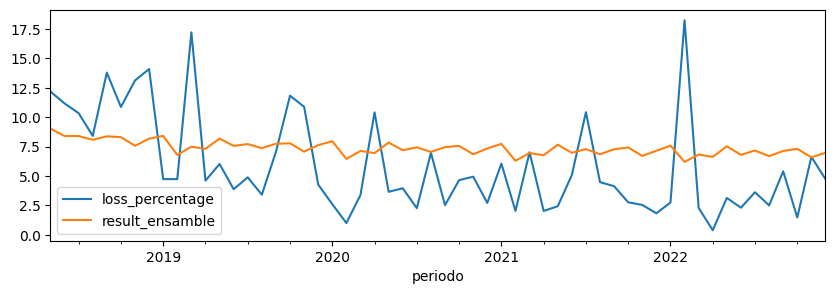

In [51]:
df_test.plot(kind = "line", y = ['loss_percentage', 'result_ensamble'],figsize=(10,3));plt.show()

Impresión de métricas para la comparación de todos los modelos utilizando como medida el Error Cuadrático Medio de Raíz

In [52]:
model_RMSE_7 = RMSE(df_test['result_ensamble'], df_test['loss_percentage'])
df_Results.loc[7, "Model"] = "Ensamble"
df_Results.loc[7, "RMSE"] = model_RMSE_7
resultados_modelos = pd.DataFrame(df_Results)
resultados_modelos.head(10)

,Model,RMSE
0,EstLinearTrend,4.845300
1,EstCuadraticTrend,3.992503
2,CubicTrend,6.636934
3,back_LogTrend,4.606147
4,Simple Smoothing a=0.9,4.430907
5,back_LogTrend + ARIMA,4.805727
6,back_LogTrend + SARIMA,4.297213
7,Ensamble,4.292018
